# **Obtención de imagenes más similares**
***


En este código se aplicará un orden jerárquico con tal de poder obtener un grupo de imagenes mas similares a una de referencia.

<a id="1"></a>
## 1. Carga de datos

Importacion de librerias

In [ ]:
#instalacion
!pip install memory-profiler
!pip install glob2
!pip install Pillow
%load_ext memory_profiler
#importacion librerias
import numpy as np
import seaborn as sns
from google.colab import drive
import os
import glob
import cv2
import tensorflow as tf
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model
from keras.models import load_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
from __future__ import annotations
from scipy.cluster.hierarchy import linkage, dendrogram
from dataclasses import dataclass
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import numpy as np
from functools import reduce
from datetime import datetime
from keras.preprocessing import image
from typing import Union

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
#conexion drive
drive.mount('/content/drive')

Carga de la red neuronal preentrenada

In [ ]:
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'

<a id="2"></a>
## 2. Definición de  funciones

Funciones requeridas por la red neuornal siamesa.

In [ ]:
def get_celebrities(n_celebrities:int, refactor_class=False):
    df1, df2 = get_max_aparicions(get_identities(), n_celebrities)
    #df.reset_index(inplace=True, drop=True)
    if refactor_class:
        df1 = refactor_identity(df1, 'Identity')
    return df1, df2


def get_max_aparicions(df:pd.DataFrame, n_celebrities:int):
    aparicions_df = df["Identity"].value_counts()
    aparicions_df = aparicions_df.reset_index()
    aparicions_df = aparicions_df.rename(columns={'Identity':'aparicions', 'index':'Identity'})
    aparicions_df = aparicions_df.iloc[:n_celebrities]
    return df[df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True), df[~df['Identity'].isin(aparicions_df['Identity'])].reset_index(drop=True)

def get_identities():
    identity_df = pd.read_csv("/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Anno/identity_CelebA.txt", sep=' ', header=None)
    identity_df = identity_df.rename(columns={0:"Image_name", 1:"Identity"})
    return identity_df

def refactor_identity(df, traget_col):
    d = get_dic_index(df, traget_col)
    df["Class"] = df.apply(lambda row: d[row[traget_col]], axis=1)
    return df

def get_dic_index(df, traget_col):
    df = df[traget_col].value_counts()
    dic_index = df.to_dict()
    i = 0
    for c in dic_index:
        dic_index[c] = i
        i += 1
    return dic_index
def get_tvt(df:pd.DataFrame, target_name:str, train_size:int):
    total_classes = df[target_name].nunique()
    n_df_col = df.shape[0]
    df = shuffle(df)
    train_df = df.iloc[:int(n_df_col*train_size)]
    val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
    test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
    while True:
        if train_df[target_name].nunique() == total_classes and val_df[target_name].nunique() == total_classes and test_df[target_name].nunique() == total_classes:
            return train_df, val_df, test_df

        df = shuffle(df)
        train_df = df.iloc[:int(n_df_col*train_size)]
        val_df = df.iloc[int(n_df_col*train_size):int(n_df_col*( train_size + (1-train_size)/2 ))]
        test_df = df.iloc[int(n_df_col*( train_size + (1-train_size)/2 )):]
class DataGenerator(Sequence):
  def __init__(self, df, batch_size=32, img_size=(200,200), img_dir= './', shuffle=True):
    self.batch_size = batch_size
    self.img_size = img_size
    self.img_dir = img_dir
    self.df = df
    self.indices = self.df.index.tolist()
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return len(self.indices) // self.batch_size

  def __getitem__(self, index):
    index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
    batch = [self.indices[k] for k in index]

    X1, X2, y = self.__get_data(batch)
    return [X1, X2], y

  def on_epoch_end(self):
    self.index = np.arange(len(self.indices))
    if self.shuffle:
      np.random.shuffle(self.index)

  def __get_data(self, batch):
    X1 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    X2 = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
    y = np.zeros((self.batch_size,), dtype="float32")
    for i, idx in enumerate(batch):
      X1[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image1'], target_size=self.img_size))
      X2[i] = img_to_array(load_img(self.img_dir + self.df.loc[idx,'Image2'], target_size=self.img_size))
      y[i] = self.df.loc[idx,'Sim']
    return X1, X2, y


class EuclideanDLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, x, y):
        sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
        return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
 def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

Carga de la red neuronal entrenada

In [ ]:
siamese = load_model('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/Weights/2023-10-07 10h 33m_test_8.best',
                     custom_objects={'KerasLayer': hub.KerasLayer,
                                     'EuclideanDLayer': EuclideanDLayer,
                                     'contrastive_loss': contrastive_loss})

<a id="3"></a>
## 3. Obtencion matriz de similitud

En este apartado se obtendrá la matriz de similitud entre las imagenes. Comentar que se ha trabajado con 25 imagenes, debido a que al obtener la matriz de similitud de las 3033 se ha superado la memoria del Drive.


**IMPORTANTE:** El siguiente codigo genera una matriz de similitud entre todas las imagenes del dataset, por lo cual, ejectuar solamente si no se ha ejecutado antes, ya que posteriormente el dataframe se guadará como un archivo de txt.

In [ ]:
directorio_imagenes = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/'
nombres_imagenes = os.listdir(directorio_imagenes)
num_imagenes = len(nombres_imagenes)
num_imagenes_a_comparar = 25
similarity_matrix = np.zeros((num_imagenes_a_comparar, num_imagenes_a_comparar), dtype=np.float32)

for i in range(num_imagenes_a_comparar):
    img1 = image.load_img(os.path.join(directorio_imagenes, nombres_imagenes[i]), target_size=(178, 218))
    img1 = image.img_to_array(img1)
    img1 = np.expand_dims(img1, axis=0)

    for j in range(i + 1, num_imagenes_a_comparar):
        img2 = image.load_img(os.path.join(directorio_imagenes, nombres_imagenes[j]), target_size=(178, 218))
        img2 = image.img_to_array(img2)
        img2 = np.expand_dims(img2, axis=0)
        embedding1 = siamese.predict([img1, img2])
        similarity_matrix[i, j] = embedding1
        similarity_matrix[j, i] = embedding1
    del img1
del siamese

df1 = pd.DataFrame(similarity_matrix, index=nombres_imagenes[:num_imagenes_a_comparar], columns=nombres_imagenes[:num_imagenes_a_comparar])
df1

Nombre al archivo de txt que guardará el dataframe de similitud.

In [ ]:
file_path = 'matriz_similitud_25.txt'
df1.to_csv(file_path, sep=',')


**IMPORTANTE:** Ejecutar el codigo aquí si ya has guardado previamente la matriz de similitud.


In [ ]:
file_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/matriz_similitud_25.txt'
md = pd.read_csv(file_path, sep=',', index_col=0)
md

,115410.jpg,115535.jpg,115591.jpg,115717.jpg,115819.jpg,116076.jpg,116077.jpg,116199.jpg,116269.jpg,116278.jpg,...,116428.jpg,116444.jpg,116509.jpg,116524.jpg,116588.jpg,116593.jpg,116601.jpg,116693.jpg,116706.jpg,116822.jpg
115410.jpg,0.000000,0.457504,0.792352,0.758970,0.984788,0.129712,0.681006,0.944355,0.661243,0.292573,...,0.974251,0.972241,0.410719,0.284378,0.278083,0.503448,0.434758,0.745632,0.963504,0.129981
115535.jpg,0.457504,0.000000,0.901704,0.991875,0.678431,0.490326,0.368647,0.320740,0.192415,0.921700,...,0.393573,0.998138,0.976950,0.169219,0.049779,0.948446,0.971355,0.963263,0.349063,0.858933
115591.jpg,0.792352,0.901704,0.000000,0.461012,0.958002,0.433797,0.472199,0.877258,0.974978,0.526497,...,0.942621,0.573266,0.788723,0.981042,0.963231,0.143289,0.267054,0.152959,0.970081,0.809666
115717.jpg,0.758970,0.991875,0.461012,0.000000,0.998981,0.817072,0.964721,0.996883,0.993865,0.587213,...,0.998721,0.181214,0.293946,0.994024,0.991457,0.116017,0.033125,0.388248,0.998522,0.808776
115819.jpg,0.984788,0.678431,0.958002,0.998981,0.000000,0.981342,0.960353,0.026455,0.938677,0.987919,...,0.021274,0.999646,0.994823,0.972961,0.932573,0.996071,0.997643,0.993470,0.111371,0.994314
116076.jpg,0.129712,0.490326,0.433797,0.817072,0.981342,0.000000,0.147001,0.916463,0.881222,0.229979,...,0.960945,0.945832,0.786835,0.640340,0.604614,0.234129,0.376945,0.298608,0.976967,0.093245
116077.jpg,0.681006,0.368647,0.472199,0.964721,0.960353,0.147001,0.000000,0.841333,0.834173,0.883240,...,0.908374,0.984658,0.981278,0.856304,0.695188,0.623117,0.846907,0.765880,0.944423,0.794109
116199.jpg,0.944355,0.320740,0.877258,0.996883,0.026455,0.916463,0.841333,0.000000,0.868396,0.958435,...,0.019239,0.998952,0.986285,0.918022,0.812896,0.984963,0.991630,0.976494,0.126628,0.977054
116269.jpg,0.661243,0.192415,0.974978,0.993865,0.938677,0.881222,0.834173,0.868396,0.000000,0.983926,...,0.902149,0.999195,0.986028,0.434926,0.116397,0.981351,0.985372,0.992906,0.503423,0.967301
116278.jpg,0.292573,0.921700,0.526497,0.587213,0.987919,0.229979,0.883240,0.958435,0.983926,0.000000,...,0.982855,0.861162,0.147859,0.911995,0.934559,0.317582,0.286293,0.157044,0.991732,0.074610


In [ ]:
md.head()

,115410.jpg,115535.jpg,115591.jpg,115717.jpg,115819.jpg,116076.jpg,116077.jpg,116199.jpg,116269.jpg,116278.jpg,...,116428.jpg,116444.jpg,116509.jpg,116524.jpg,116588.jpg,116593.jpg,116601.jpg,116693.jpg,116706.jpg,116822.jpg
115410.jpg,0.000000,0.457504,0.792352,0.758970,0.984788,0.129712,0.681006,0.944355,0.661243,0.292573,...,0.974251,0.972241,0.410719,0.284378,0.278083,0.503448,0.434758,0.745632,0.963504,0.129981
115535.jpg,0.457504,0.000000,0.901704,0.991875,0.678431,0.490326,0.368647,0.320740,0.192415,0.921700,...,0.393573,0.998138,0.976950,0.169219,0.049779,0.948446,0.971355,0.963263,0.349063,0.858933
115591.jpg,0.792352,0.901704,0.000000,0.461012,0.958002,0.433797,0.472199,0.877258,0.974978,0.526497,...,0.942621,0.573266,0.788723,0.981042,0.963231,0.143289,0.267054,0.152959,0.970081,0.809666
115717.jpg,0.758970,0.991875,0.461012,0.000000,0.998981,0.817072,0.964721,0.996883,0.993865,0.587213,...,0.998721,0.181214,0.293946,0.994024,0.991457,0.116017,0.033125,0.388248,0.998522,0.808776
115819.jpg,0.984788,0.678431,0.958002,0.998981,0.000000,0.981342,0.960353,0.026455,0.938677,0.987919,...,0.021274,0.999646,0.994823,0.972961,0.932573,0.996071,0.997643,0.993470,0.111371,0.994314


<a id="4"></a>
## 4. Creación arbol jerárquico

En este apartado se generará la estructura jerárquica de los datos.

 Calculo de las distancias entre grupos de datos. En este caso,calculando enlaces jerárquicos entre observaciones.

In [ ]:
linked = linkage(md, method='ward')

<ipython-input-8-268515e74d98>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(md, method='ward')


Esta función se utiliza para visualizar el dendrograma resultante de la vinculación jerárquica. Toma como entrada la información de enlace generada por linkage.

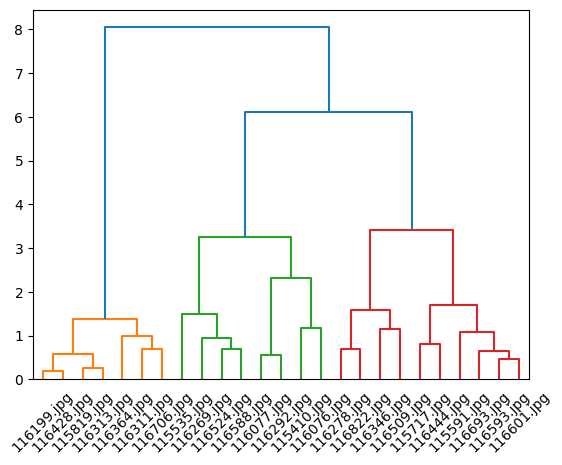

In [ ]:
dendrogram_result = dendrogram(linked, labels=md.index, orientation='top')

Por último se genera un diccionario llamado diccionari donde las claves son índices de filas ('leaves') obtenidos de un DataFrame llamado dendrogram_result, y los valores son nombres de archivos de imágenes correspondientes a esos índices, extraídos de otro DataFrame llamado md. Es decir, asocia los índices de un dendrograma con los nombres de archivos de imágenes específicos. Por ejemplo, la clave 7 está asociada con '116199.jpg', la clave 15 con '116428.jpg', y así sucesivamente.

In [ ]:
diccionari = {i:md.index[i] for i in dendrogram_result['leaves']}
diccionari

{7: '116199.jpg',
 15: '116428.jpg',
 4: '115819.jpg',
 12: '116313.jpg',
 14: '116364.jpg',
 11: '116311.jpg',
 23: '116706.jpg',
 1: '115535.jpg',
 8: '116269.jpg',
 18: '116524.jpg',
 19: '116588.jpg',
 6: '116077.jpg',
 10: '116292.jpg',
 0: '115410.jpg',
 5: '116076.jpg',
 9: '116278.jpg',
 24: '116822.jpg',
 13: '116346.jpg',
 17: '116509.jpg',
 3: '115717.jpg',
 16: '116444.jpg',
 2: '115591.jpg',
 22: '116693.jpg',
 20: '116593.jpg',
 21: '116601.jpg'}

## Definición de la matrix linkage Z
La matriz de vinculación Z es una matriz de tamaño $(n-1) \times 4$. En cada iteración $i$, se combinan los clusters con índices $Z[i, 0]$ y $Z[i, 1]$ para formar un nuevo cluster con índice $n+i$. Un cluster con un índice menor que $n$ corresponde a una de las $n$ observaciones originales. La distancia entre los clusters $Z[i, 0]$ y $Z[i, 1]$ se da en $Z[i, 2]$, y el cuarto valor $Z[i, 3]$ representa la cantidad de observaciones originales en el nuevo cluster formado.

In [ ]:
linked

array([[ 7.        , 15.        ,  0.18243296,  2.        ],
       [ 4.        , 12.        ,  0.26141367,  2.        ],
       [20.        , 21.        ,  0.46622921,  2.        ],
       [ 6.        , 10.        ,  0.54572516,  2.        ],
       [25.        , 26.        ,  0.58741482,  4.        ],
       [22.        , 27.        ,  0.65668221,  3.        ],
       [ 9.        , 24.        ,  0.68029887,  2.        ],
       [11.        , 23.        ,  0.68412122,  2.        ],
       [18.        , 19.        ,  0.6947269 ,  2.        ],
       [ 3.        , 16.        ,  0.7963684 ,  2.        ],
       [ 8.        , 33.        ,  0.95375897,  3.        ],
       [14.        , 32.        ,  0.98599414,  3.        ],
       [ 2.        , 30.        ,  1.09096779,  4.        ],
       [13.        , 17.        ,  1.15918083,  2.        ],
       [ 0.        ,  5.        ,  1.16653114,  2.        ],
       [29.        , 36.        ,  1.37677087,  7.        ],
       [ 1.        , 35.

## Recorrer el arbol

El código define dos clases, Nodo y Img. La clase Nodo representa los nodos del árbol binario, mientras que la clase Img representa imágenes. Además, se establece un alias ArBin que puede ser un objeto de la clase Nodo o Img, modelando así una estructura de árbol binario con nodos y hojas.

In [ ]:
@dataclass
class Nodo:
    idx: int
    num: int
    dist: float
    ejemplo: str
    izq: 'ArBin'
    der: 'ArBin'
    total_imagenes: int = 0

@dataclass
class Img:
    idx: int
    ejemplo: str


ArBin = Union[Nodo, Img]

La función 'creacio' es recursiva que crea y devuelve un objeto de tipo Nodo o Img, dependiendo de las condiciones, seguidamente calcula la cantidad total de imágenes en los subárboles izquierdo y derecho,  obteniendo el numero de imagenes de cada nodo.

In [ ]:
def creacio(n, num, linked, diccionari):
    if n < num:
        return Img(idx=n, ejemplo=diccionari[n])
    else:
        i = n - num
        izq = creacio(int(linked[i, 0]), num, linked, diccionari)
        der = creacio(int(linked[i, 1]), num, linked, diccionari)
        total_imagenes = 1 + sum_imagenes(izq) + sum_imagenes(der)
        total_imagenes -= 1  # Subtract 1 from total_imagenes
        return Nodo(idx=n, num=linked[i, 3], dist=linked[i, 2], ejemplo=izq.ejemplo, izq=izq, der=der, total_imagenes=total_imagenes)

La función show se utiliza para visualizar la estructura de datos del árbol binario de manera jerárquica, lo que facilita la comprensión de la relación entre nodos y objetos de imagen en el árbol.

In [ ]:

def show(a, n):
    if isinstance(a, Img):
        print("  " * n, f"Img ({a.idx}): {a.ejemplo}")
    else:
        print("  " * n, f"Nodo ({a.idx}): {a.num} {a.dist} {a.ejemplo} Total imágenes: {a.total_imagenes}")
        show(a.izq, n + 1)
        show(a.der, n + 1)

Las siguientes funciones están diseñadas para manipular y analizar dendrogramas que representan estructuras de árboles.
- La función sum_imagenes calcula la cantidad total de imágenes en un subárbol.
- Cortar_arbol fragmenta el árbol según un límite de imágenes.
- Get_images_from_tree recopila todas las imágenes en el árbol.
- Las funciones generate_df_from_tree y generate_df_with_similarity crean DataFrames con la similitud de las imágenes con una referencia usando un modelo de siames.

In [ ]:
def sum_imagenes(arbol):
    if isinstance(arbol, Nodo):
        return arbol.total_imagenes
    elif isinstance(arbol, Img):
        return 1
    else:
        return 0


def cortar_arbol(arbol, objetivo):
    if arbol.total_imagenes <= objetivo:
        return arbol
    elif isinstance(arbol.izq, Nodo) and arbol.izq.total_imagenes >= objetivo:
        return cortar_arbol(arbol.izq, objetivo)
    else:
        return cortar_arbol(arbol.der, objetivo)

def get_images_from_tree(arbol):
    if isinstance(arbol, Nodo):
        images = [arbol.ejemplo]
        images += get_images_from_tree(arbol.izq)
        images += get_images_from_tree(arbol.der)
        return images
    elif isinstance(arbol, Img):
        return [arbol.ejemplo]
    else:
        return []
import pandas as pd

def generate_df_from_tree(dendrograma, objetivo_imagenes):
    arbol_cortado = cortar_arbol(dendrograma, objetivo_imagenes)
    print("Cut Dendrogram (Objective Images:", objetivo_imagenes, "):")
    show(arbol_cortado, 0)
    todas_las_imagenes = get_images_from_tree(arbol_cortado)
    df_arbol = pd.DataFrame({"Imagen": todas_las_imagenes}).reset_index(drop=True)
    df_arbol = df_arbol.drop_duplicates(subset="Imagen").reset_index(drop=True)
    return df_arbol

def generate_df_with_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size):
    arbol_cortado = cortar_arbol(dendrograma, objetivo_imagenes)
    todas_las_imagenes = get_images_from_tree(arbol_cortado)
    df_arbol = pd.DataFrame({"Imagen": todas_las_imagenes}).reset_index(drop=True)
    df_arbol = df_arbol.drop_duplicates(subset="Imagen").reset_index(drop=True)
    df_arbol['Sim'] = np.nan
    img_reference = image.load_img(reference_image_path, target_size=target_size)
    img_reference = image.img_to_array(img_reference)
    img_reference = np.expand_dims(img_reference, axis=0)


    for i, row in df_arbol.iterrows():
        image_path = f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/{row["Imagen"]}'
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        df_arbol.at[i, 'Sim'] =similarity[0][0]
    return df_arbol

Generación del dendrograma a partir de datos en las matrices linked y diccionari, utilizando la función creacio para construir la estructura del árbol. El número de filas en la matriz md se utiliza para determinar la longitud del dendrograma. Finalmente, la función show visualiza el dendrograma generado, proporcionando una representación gráfica de la jerarquía de los datos.

In [ ]:
num = md.shape[0]
dendrograma = creacio(num * 2 - 2, num, linked, diccionari)
show(dendrograma, 0)

 Nodo (48): 25.0 8.04728236958203 116199.jpg Total imágenes: 25
   Nodo (40): 7.0 1.3767708660580016 116199.jpg Total imágenes: 7
     Nodo (29): 4.0 0.5874148181544739 116199.jpg Total imágenes: 4
       Nodo (25): 2.0 0.1824329581529062 116199.jpg Total imágenes: 2
         Img (7): 116199.jpg
         Img (15): 116428.jpg
       Nodo (26): 2.0 0.2614136714857884 115819.jpg Total imágenes: 2
         Img (4): 115819.jpg
         Img (12): 116313.jpg
     Nodo (36): 3.0 0.9859941443131202 116364.jpg Total imágenes: 3
       Img (14): 116364.jpg
       Nodo (32): 2.0 0.6841212189523337 116311.jpg Total imágenes: 2
         Img (11): 116311.jpg
         Img (23): 116706.jpg
   Nodo (47): 18.0 6.114836963980827 115535.jpg Total imágenes: 18
     Nodo (45): 8.0 3.253860168741922 115535.jpg Total imágenes: 8
       Nodo (41): 4.0 1.4886545006235103 115535.jpg Total imágenes: 4
         Img (1): 115535.jpg
         Nodo (35): 3.0 0.9537589735820399 116269.jpg Total imágenes: 3
           Im


Se establece la variable 'objetivo_imagenes' y luego se utiliza la función 'generate_df_from_tree' para crear el DataFrame 'df_arbol'. Este DataFrame contiene las imágenes presentes en el dendrograma, siguiendo la segmentación definida por 'objetivo_imagenes'. Al finalizar, el código imprime tanto el dendrograma como el DataFrame después de aplicar el corte.

In [ ]:
objetivo_imagenes = 10
df_arbol = generate_df_from_tree(dendrograma, objetivo_imagenes)
print("\nDataFrame with Unique Images from Cut Tree:")
df_arbol

Cut Dendrogram (Objective Images: 10 ):
 Nodo (46): 10.0 3.415170431680442 116278.jpg Total imágenes: 10
   Nodo (42): 4.0 1.5810384924305447 116278.jpg Total imágenes: 4
     Nodo (31): 2.0 0.6802988703108445 116278.jpg Total imágenes: 2
       Img (9): 116278.jpg
       Img (24): 116822.jpg
     Nodo (38): 2.0 1.1591808347123211 116346.jpg Total imágenes: 2
       Img (13): 116346.jpg
       Img (17): 116509.jpg
   Nodo (43): 6.0 1.706663645512069 115717.jpg Total imágenes: 6
     Nodo (34): 2.0 0.7963683996607506 115717.jpg Total imágenes: 2
       Img (3): 115717.jpg
       Img (16): 116444.jpg
     Nodo (37): 4.0 1.0909677918945153 115591.jpg Total imágenes: 4
       Img (2): 115591.jpg
       Nodo (30): 3.0 0.6566822075376104 116693.jpg Total imágenes: 3
         Img (22): 116693.jpg
         Nodo (27): 2.0 0.46622920810391794 116593.jpg Total imágenes: 2
           Img (20): 116593.jpg
           Img (21): 116601.jpg

DataFrame with Unique Images from Cut Tree:


,Imagen
0,116278.jpg
1,116822.jpg
2,116346.jpg
3,116509.jpg
4,115717.jpg
5,116444.jpg
6,115591.jpg
7,116693.jpg
8,116593.jpg
9,116601.jpg


<a id="5"></a>
## 5. Busqueda de los mas cercanos

En este penúltimo apartado se programarán las funciones requeridas para que al introducir una imagen de referencia, se encuentre la imagen más similar a la imagen de referencia siguiendo una estructura de nodos jerárquica y utilizando un modelo Siamese para calcular las similitudes.




Las siguientes funciones están relacionadas con el cálculo y procesamiento de similitudes entre imágenes del dendrograma jerárquico:
- Calculate_similarity_recursive calcula la similitud entre una imagen de referencia y las imágenes en el dendrograma de manera recursiva.
- Apply_similarity_to_tree_and_build_dataframe aplica la similitud a todo el dendrograma y construye un DataFrame con los resultados. -Calculate_and_adjust_similarity calcula y ajusta las similitudes.
-Process_similarity_dataframe procesa y organiza el DataFrame resultante.
- Visualize_pair, toma una imagen de referencia, su nombre y la similitud con otra imagen asociada. Luego, muestra ambas imágenes en una figura de dos subgráficos.

In [ ]:
def visualize_pair(imagen_referencia, nombre_imagen, similitud):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Similitud: {similitud}', size=16)
    img_referencia = mpimg.imread(imagen_referencia)
    ax1.imshow(img_referencia)
    ax1.set_title('Imagen de Referencia')
    ax1.axis('off')
    img_asociada = mpimg.imread(f'/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/{nombre_imagen}')
    ax2.imshow(img_asociada)
    ax2.set_title(f'Imagen Asociada: {nombre_imagen}')
    ax2.axis('off')

    plt.show()


def calculate_similarity_recursive(df_result, arbol, reference_image_path, siamese, target_size, threshold=0.5):
    if isinstance(arbol, Nodo):
        img_reference = image.load_img(reference_image_path, target_size=target_size)
        img_reference = image.img_to_array(img_reference)
        img_reference = np.expand_dims(img_reference, axis=0)
        image_path = os.path.join('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/', arbol.ejemplo)
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        if similarity[0][0] <= threshold:
            df_result = calculate_similarity_recursive(df_result, arbol.izq, reference_image_path, siamese, target_size, threshold)
        else:
            df_result = calculate_similarity_recursive(df_result, arbol.der, reference_image_path, siamese, target_size, threshold)
        df_temp = pd.DataFrame({"Imagen": [arbol.ejemplo], "Similitud": [similarity[0][0]]})
        df_result = pd.concat([df_result, df_temp], ignore_index=True)
    elif isinstance(arbol, Img):
        img_reference = image.load_img(reference_image_path, target_size=target_size)
        img_reference = image.img_to_array(img_reference)
        img_reference = np.expand_dims(img_reference, axis=0)
        image_path = os.path.join('/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/cut_faces/', arbol.ejemplo)
        img_df = image.load_img(image_path, target_size=target_size)
        img_df = image.img_to_array(img_df)
        img_df = np.expand_dims(img_df, axis=0)
        similarity = siamese.predict([img_reference, img_df])
        df_temp = pd.DataFrame({"Imagen": [arbol.ejemplo], "Similitud": [similarity[0][0]]})
        df_result = pd.concat([df_result, df_temp], ignore_index=True)

    return df_result


def apply_similarity_to_tree_and_build_dataframe(dendrograma, reference_image_path, siamese, target_size, threshold=0.5):
    df_result = pd.DataFrame(columns=["Imagen", "Similitud"])
    df_result = calculate_similarity_recursive(df_result, dendrograma, reference_image_path, siamese, target_size, threshold)
    return df_result

def calculate_and_adjust_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size):
    df_with_similarity = generate_df_with_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size)
    df_with_similarity = df_with_similarity.sort_values(by='Sim', ascending=True).reset_index(drop=True)
    df_with_similarity['Sim'] = 1 - df_with_similarity['Sim']

    return df_with_similarity

def process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size):
    df_result = apply_similarity_to_tree_and_build_dataframe(dendrograma, reference_image_path, siamese, target_size)
    df_result = df_result.drop_duplicates(subset="Imagen").reset_index(drop=True)
    df_result = df_result.sort_values(by="Similitud", ascending=True).reset_index(drop=True)
    df_result["Similitud"] = 1 - df_result["Similitud"]

    return df_result

# <a id="6"></a>
## 6. Resultados

En este apartado se estabelecerán 3 imagenes de referncia distintas para ver si el modelo devuelve las imagenes más similares a estas.

La metódica se repite para los 3 casos:


1.   Primero generamos un dataframe donde aparecen todas las imagenes existentes en el árbol, y calculamos la similiutd con la imagen de referencia.
2.   Recorremos el arbol y se almacenan las imagenes que van siendo más similares a la imagen de referencia.
3.   Se impre la imagen de referencia junto a las obtenidas tras recorrer el arbol.



Definición del tamaño que la red siamesa espera obtener las imagenes.

In [ ]:
target_size = (178, 218)


# **PRUEBA 1**

In [ ]:
objetivo_imagenes = 25
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/202017.jpg'
df_with_similarity = calculate_and_adjust_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size)
print("\nDataFrame with Adjusted Similarity Scores:")
df_with_similarity

1/1 [==============================] - 0s 30ms/step

DataFrame with Adjusted Similarity Scores:


,Imagen,Sim
0,116706.jpg,0.858496
1,116364.jpg,0.857360
2,116199.jpg,0.854015
3,116428.jpg,0.827121
4,115819.jpg,0.818799
5,116292.jpg,0.360843
6,116313.jpg,0.342009
7,115535.jpg,0.338556
8,116077.jpg,0.188379
9,116269.jpg,0.165923


In [ ]:
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/202017.jpg'
df_result_processed = process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size)
df_result_processed

1/1 [==============================] - 0s 45ms/step


,Imagen,Similitud
0,116199.jpg,0.854015


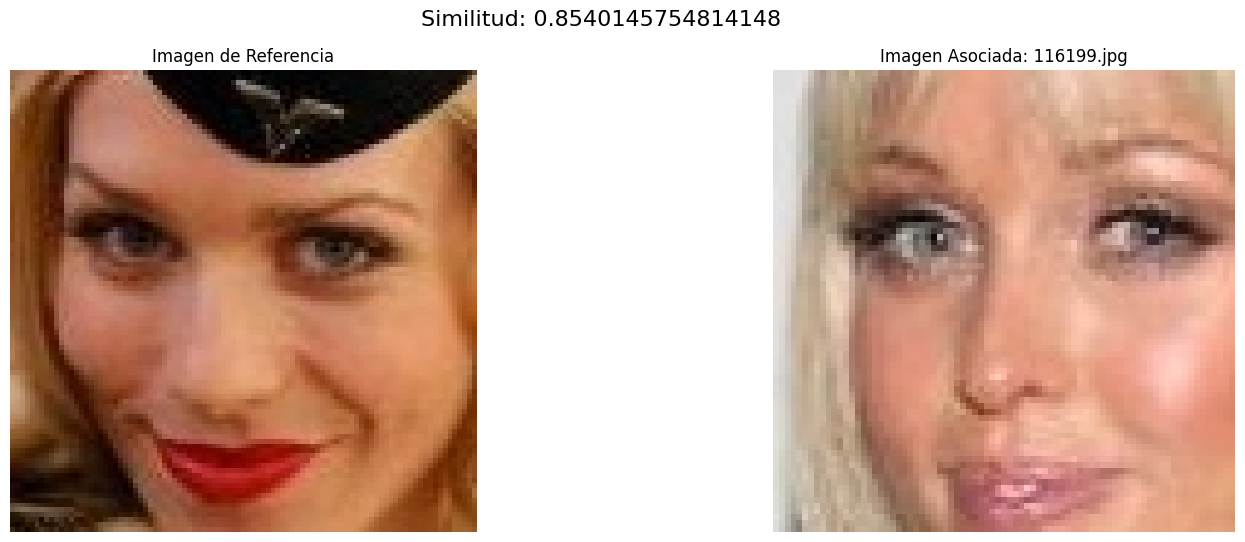

In [ ]:
for index, row in df_result_processed.iterrows():
    nombre_imagen = row['Imagen']
    similitud = row['Similitud']
    visualize_pair(reference_image_path, nombre_imagen, similitud)

# **PRUEBA 2**

In [ ]:
objetivo_imagenes = 25
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/115717.jpg'
df_with_similarity = calculate_and_adjust_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size)
print("\nDataFrame with Adjusted Similarity Scores:")
df_with_similarity

1/1 [==============================] - 0s 27ms/step

DataFrame with Adjusted Similarity Scores:


,Imagen,Sim
0,115717.jpg,0.994346
1,116601.jpg,0.966875
2,116593.jpg,0.883982
3,116444.jpg,0.818786
4,116509.jpg,0.706054
5,116693.jpg,0.611752
6,115591.jpg,0.538988
7,116278.jpg,0.412788
8,115410.jpg,0.241029
9,116822.jpg,0.191224


In [ ]:
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/115717.jpg'
df_result_processed = process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size)
df_result_processed

1/1 [==============================] - 0s 48ms/step


,Imagen,Similitud
0,115717.jpg,0.994346
1,116278.jpg,0.412788
2,115535.jpg,0.008125
3,116199.jpg,0.003117


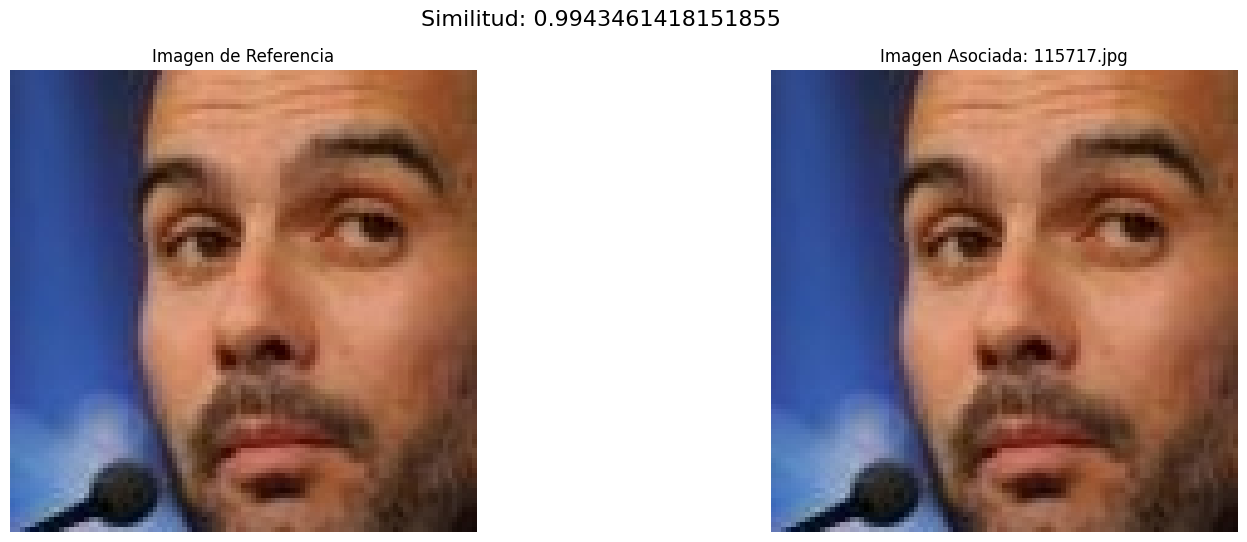

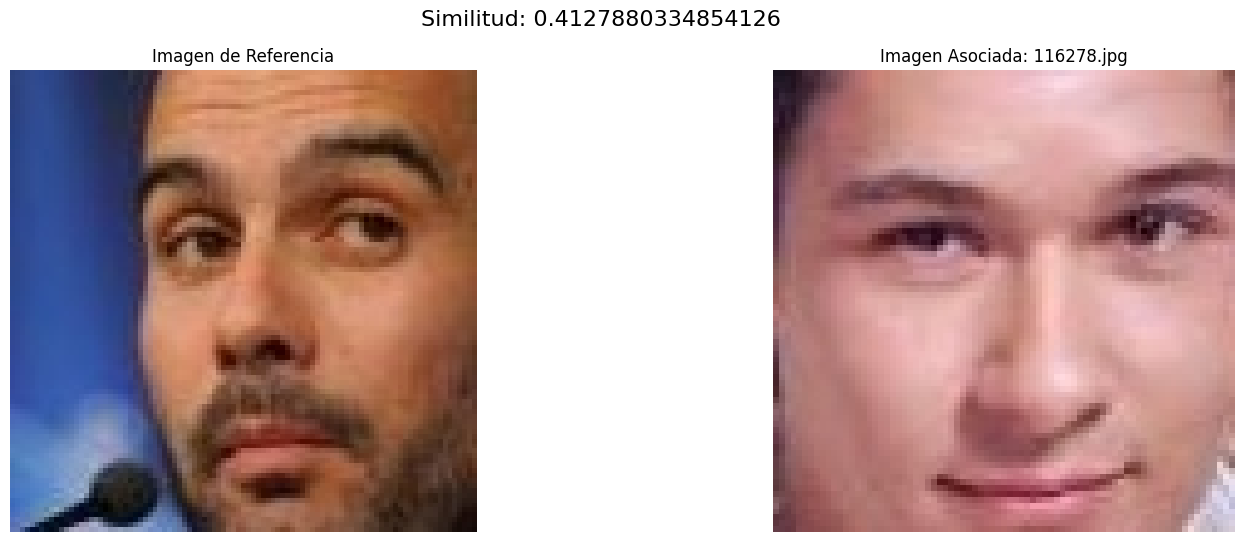

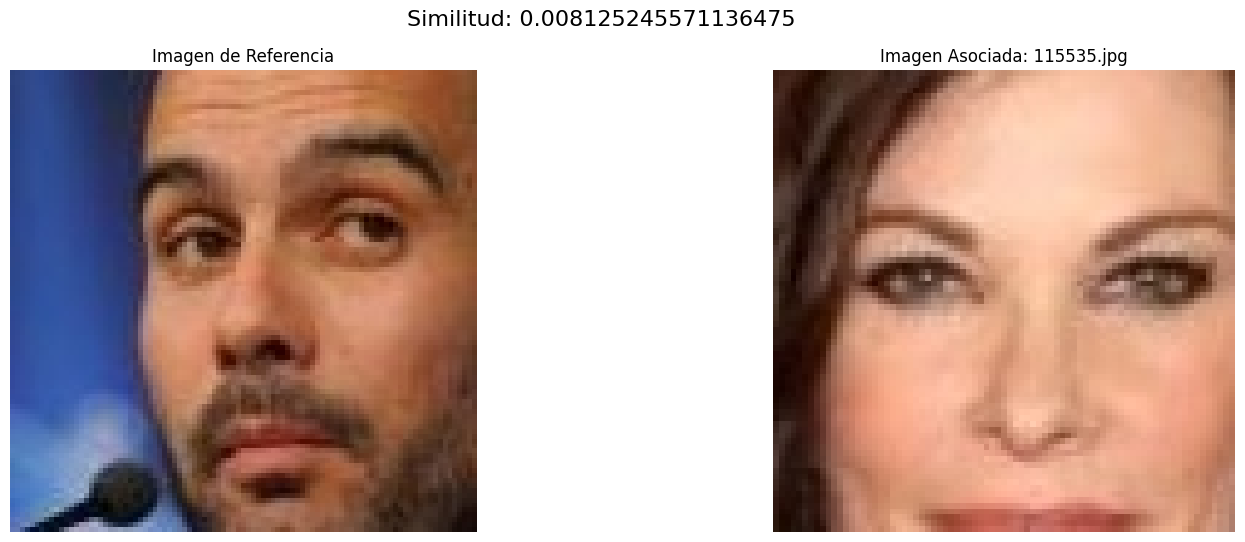

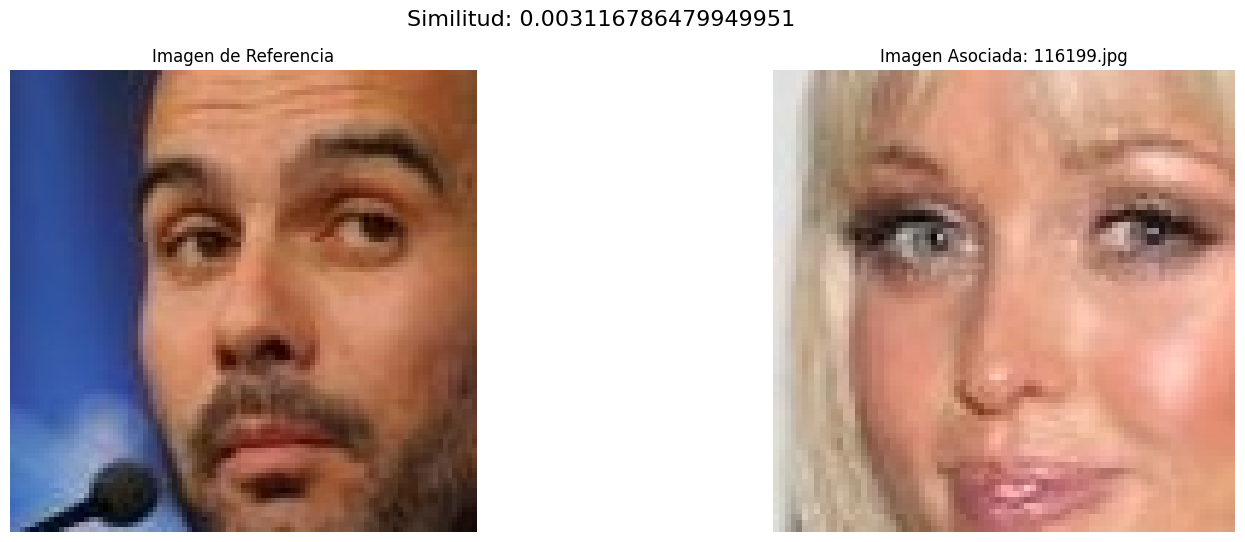

In [ ]:
for index, row in df_result_processed.iterrows():
    nombre_imagen = row['Imagen']
    similitud = row['Similitud']
    visualize_pair(reference_image_path, nombre_imagen, similitud)

# **PRUEBA 3**

In [ ]:
objetivo_imagenes = 25
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/116278.jpg'
df_with_similarity = calculate_and_adjust_similarity(dendrograma, objetivo_imagenes, reference_image_path, siamese, target_size)
print("\nDataFrame with Adjusted Similarity Scores:")
df_with_similarity

1/1 [==============================] - 0s 28ms/step

DataFrame with Adjusted Similarity Scores:


,Imagen,Sim
0,116278.jpg,0.994346
1,116822.jpg,0.925390
2,116346.jpg,0.890964
3,116509.jpg,0.852141
4,116693.jpg,0.842957
5,116076.jpg,0.770020
6,116601.jpg,0.713707
7,115410.jpg,0.707426
8,116593.jpg,0.682418
9,115591.jpg,0.473500


In [ ]:
reference_image_path = '/content/drive/My Drive/TFG/BLOQUE_1/CelebA/Img/img_prueba/116278.jpg'
df_result_processed = process_similarity_dataframe(dendrograma, reference_image_path, siamese, target_size)
df_result_processed

1/1 [==============================] - 0s 41ms/step


,Imagen,Similitud
0,116278.jpg,0.994346
1,115535.jpg,0.078300
2,116199.jpg,0.041564


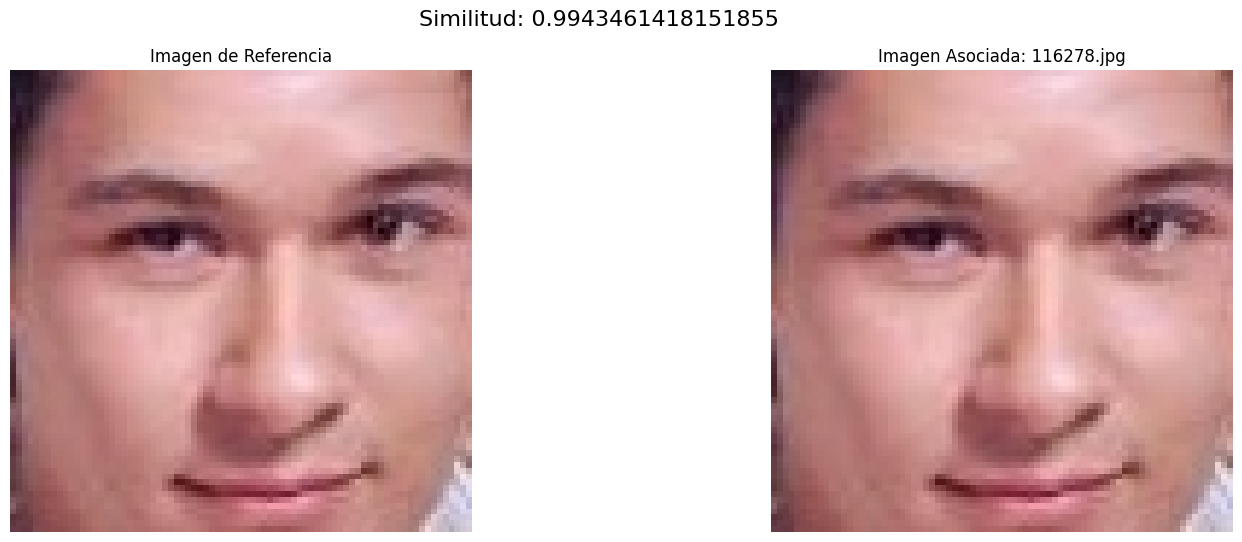

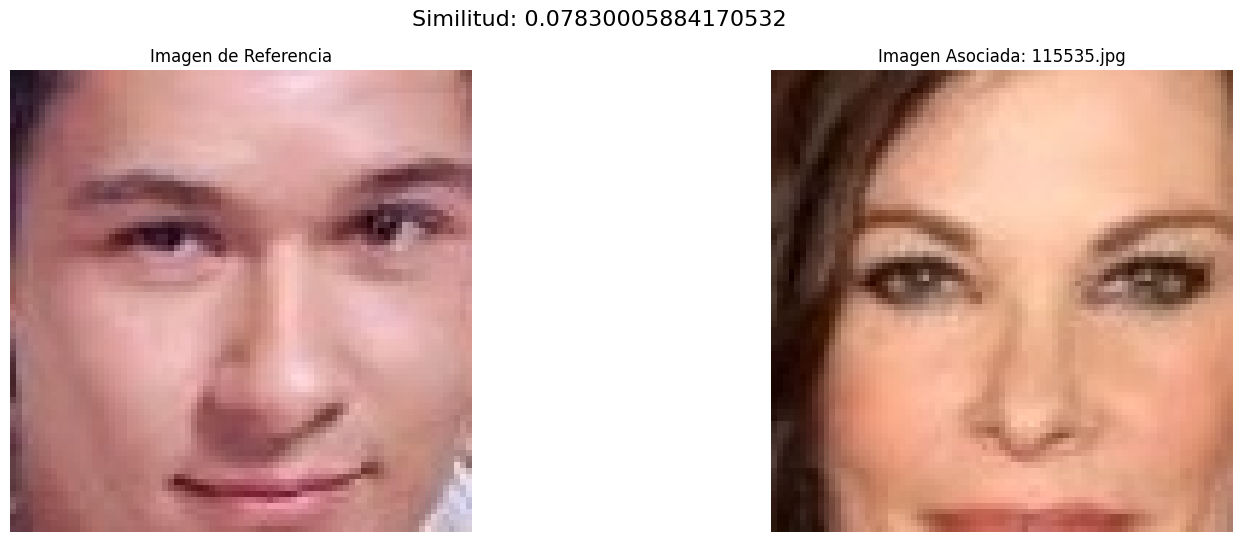

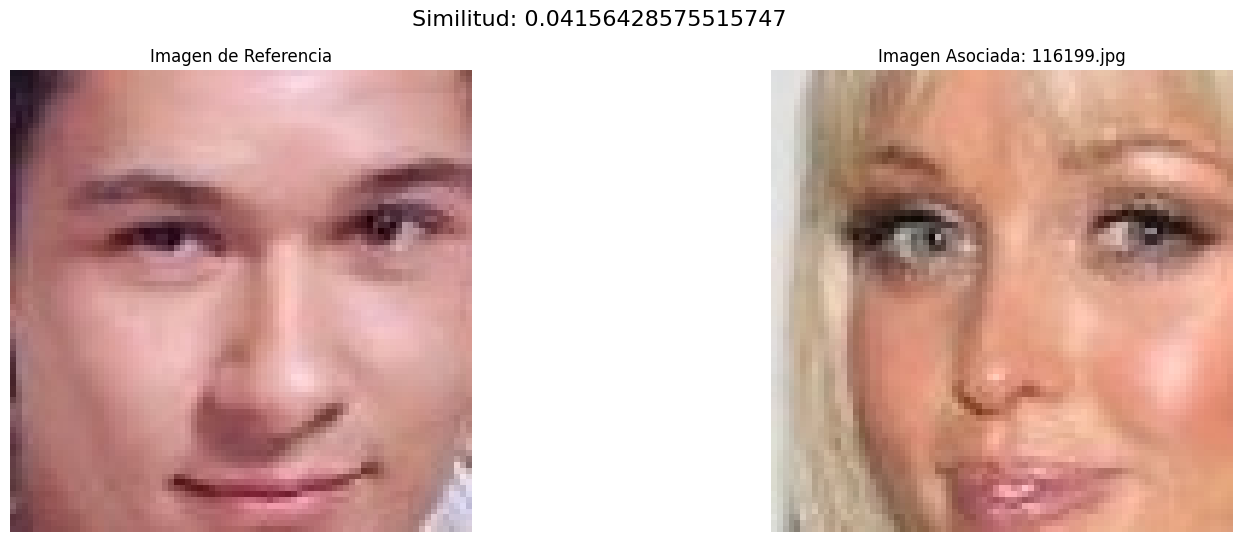

In [ ]:
for index, row in df_result_processed.iterrows():
    nombre_imagen = row['Imagen']
    similitud = row['Similitud']
    visualize_pair(reference_image_path, nombre_imagen, similitud)